In [15]:
# Import libs

import esda  
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from pylab import figure, scatter, show
%matplotlib inline
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import seaborn as sns
from scipy.stats import gaussian_kde

# 1. Load & Preprocess data

In [16]:
# Load & merge: airbnb and deprivation

airbnb=pd.read_csv("data/grouped_data.csv")[['GSS_CODE','Count_','average_price']]
dep=pd.read_excel("data/2019_deprivation.xlsx").drop(columns=['old_ward_code'])
dep.rename(columns={'NEW_CODE':'GSS_CODE'},inplace=True)

rawData=pd.merge(dep, airbnb, on='GSS_CODE', how='inner')
rawData['average_price'] = pd.to_numeric(rawData['average_price'], errors='coerce')
display(rawData)

GSS_CODE  IMD Score  Income Score (rate)  Employment Score (rate)  \
0    E09000001  16.117500             0.085833                 0.061917   
1    E05000026  31.383286             0.193000                 0.096571   
2    E05000027  35.591333             0.215167                 0.138333   
3    E05000028  35.124857             0.205286                 0.127143   
4    E05000029  31.828833             0.187500                 0.119833   
..         ...        ...                  ...                      ...   
620  E05000645  17.425833             0.122167                 0.077167   
621  E05000646  20.191333             0.144667                 0.110833   
622  E05000647  18.662500             0.144167                 0.087167   
623  E05000648  31.070667             0.231111                 0.154667   
624  E05000649  17.389167             0.079333                 0.060333   

     Education, Skills and Training Score  \
0                                8.252750   
1                               17.351000   
2                               26.628333   
3                               26.718000   
4                               26.318500   
..                                    ...   
620                              5.143000   
621                              5.600167   
622                              4.300167   
623                             12.035444   
624                              4.984333   

     Health Deprivation and Disability Score  Crime Score  \
0                                  -0.779000    -1.662667   
1                                   0.017571     0.604143   
2                                   0.397500     0.616333   
3                                   0.396143     0.675429   
4                                   0.193833     0.602000   
..                                       ...          ...   
620                                -0.635667    -0.102500   
621                                -0.458667    -0.616167   
622                                -0.585500    -0.163333   
623                                 0.052889     0.442667   
624                                -0.999000     0.237000   

     Barriers to Housing and Services Score  Living Environment Score  Count_  \
0                                 35.478667                 35.398083     537   
1                                 49.879714                 33.769571      91   
2                                 45.833333                 26.589833      26   
3                                 44.738000                 32.776000      32   
4                                 43.294167                 24.275000      19   
..                                      ...                       ...     ...   
620                               23.131500                 39.542167     243   
621                               22.207667                 42.214833     231   
622                               22.825500                 40.768833     453   
623                               25.095556                 35.883778     284   
624                               25.459333                 56.627667    1422   

     average_price  
0           243.96  
1           132.63  
2            91.12  
3           112.56  
4            75.79  
..             ...  
620         290.62  
621         239.20  
622         234.96  
623         214.72  
624         435.65  

[625 rows x 11 columns]

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


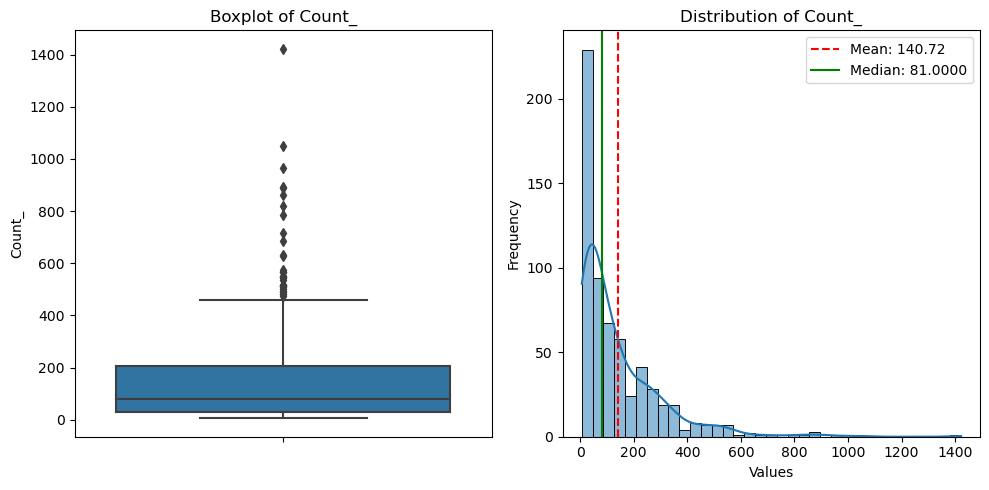

The standard deviation of Count_ is: 163.7744250407734


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


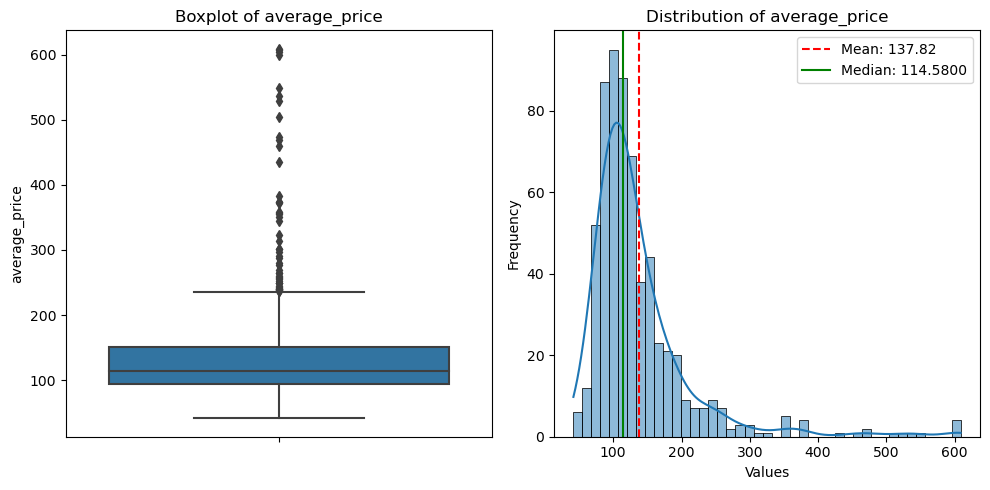

The standard deviation of average_price is: 78.25946661495942


In [17]:
def get_statistics_feature(data,name):
    column_values=data[name]
    
    mean = column_values.mean()
    std = column_values.std()
    median = column_values.median()
    quartiles = column_values.quantile([0.25, 0.5, 0.75])
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(y=column_values)
    plt.title(f'Boxplot of {name}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(column_values, kde=True)
    plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.4f}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Distribution of {name}')
    
    plt.tight_layout()
    plt.show()
    print(f'The standard deviation of {name} is: {std}')
get_statistics_feature(rawData,"Count_")
get_statistics_feature(rawData,"average_price")

GSS_CODE                                           geometry
0    E05000405  POLYGON ((516401.600 160201.800, 516407.300 16...
1    E05000414  POLYGON ((517829.600 165447.100, 517837.100 16...
2    E05000401  POLYGON ((518107.500 167303.400, 518114.300 16...
3    E05000400  POLYGON ((520480.000 166909.800, 520490.700 16...
4    E05000402  POLYGON ((522071.000 168144.900, 522063.900 16...
..         ...                                                ...
620  E05000042  POLYGON ((549410.700 187450.700, 549391.200 18...
621  E05000030  POLYGON ((549991.500 184928.500, 549988.900 18...
622  E05000029  POLYGON ((547715.200 187914.200, 547712.500 18...
623  E05000037  POLYGON ((547381.600 185753.600, 547377.500 18...
624  E09000001  POLYGON ((531361.300 180691.000, 531313.200 18...

[625 rows x 2 columns]

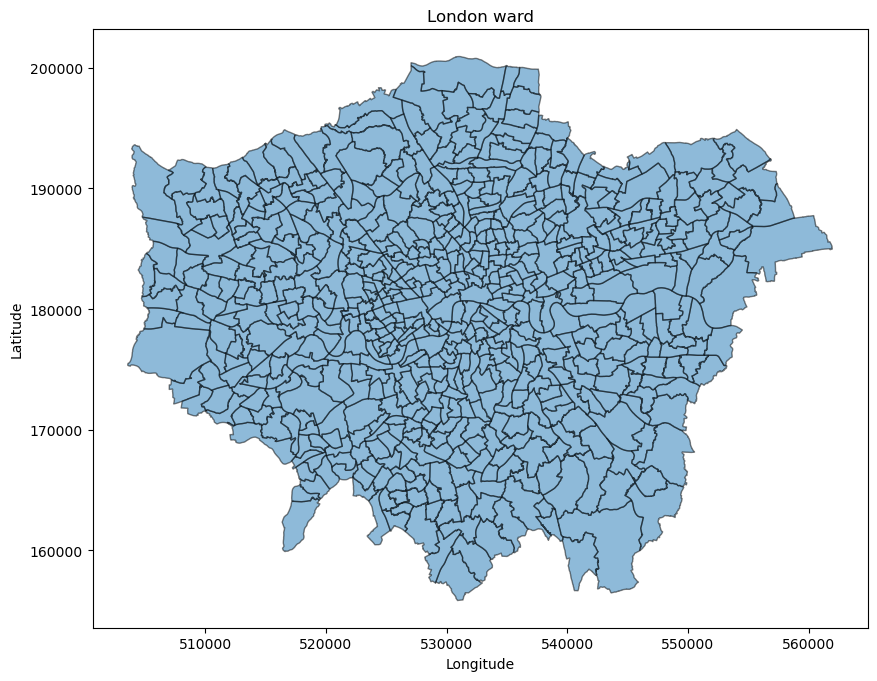

In [19]:
# Load & plot: London ward (city merged)

map=gpd.read_file('data/London_Ward_CityMerged.shp')[['GSS_CODE','geometry']]

display(map)
map.plot(figsize=(10, 8), alpha=0.5, edgecolor='k')
plt.title('London ward')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/tmp/ipykernel_3965/2447119315.py:47: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  listData = pd.read_csv('data/listings.csv')
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


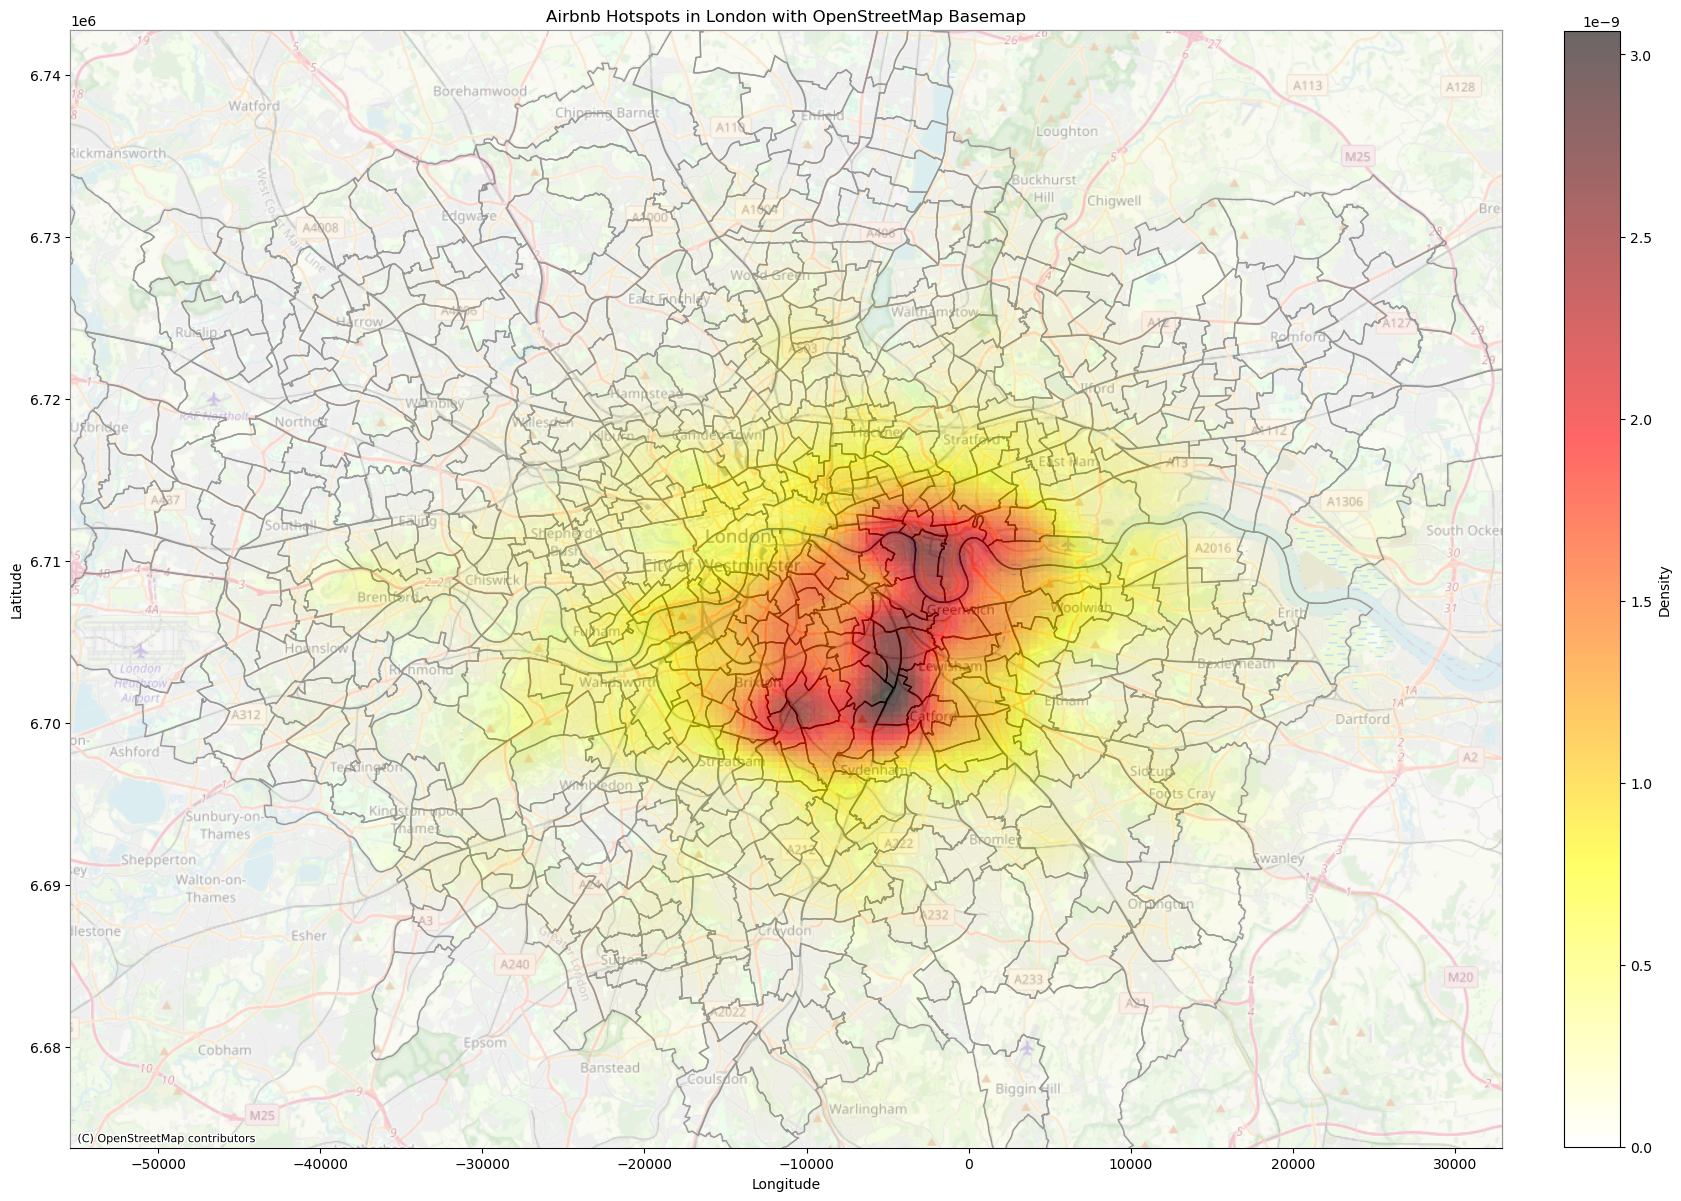

In [11]:
def get_kde(airbnb_gdf,map):
    airbnb_gdf = airbnb_gdf.to_crs(epsg=3857)
    myMap = map.to_crs(epsg=3857)
    
    # calculate KDE
    
    longitude = airbnb_gdf.geometry.x
    latitude = airbnb_gdf.geometry.y
    
    xy = np.vstack([longitude, latitude])
    kde = gaussian_kde(xy, bw_method= 'silverman') # bw_method='scott' bw_method='silverman' bw_method=0.1
    
    grid_x, grid_y = np.mgrid[longitude.min():longitude.max():200j, latitude.min():latitude.max():200j]
    grid_coords = np.vstack([grid_x.ravel(), grid_y.ravel()])
    z = kde(grid_coords).reshape(grid_x.shape)
    
    # plot
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # plot London borough
    myMap.plot(ax=ax, color='none', edgecolor='black', zorder=2)
    
    # plot kernel density layers
    im = ax.imshow(z, origin='lower', extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()], cmap=plt.cm.hot_r, alpha=0.6, zorder=3)
    
    # plot OpenStreetMap 
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zorder=1)
    
    # adjusting the axes to fit the drawing
    ax.set_xlim(longitude.min(), longitude.max())
    ax.set_ylim(latitude.min(), latitude.max())
    
    # add a colour bar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
    cbar.set_label('Density')
    
    # set x,y axis
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # set title
    ax.set_title('Airbnb Hotspots in London with OpenStreetMap Basemap')
    
    plt.show()
    
listData = pd.read_csv('data/listings.csv')
geometry = [Point(xy) for xy in zip(listData['longitude'], listData['latitude'])]
crs = {'init': 'epsg:4326'} 
airbnb_gdf = gpd.GeoDataFrame(listData, geometry=geometry, crs=crs)
get_kde(airbnb_gdf,map)

In [20]:
# Merge & View: data & map

myData=pd.merge(rawData, map, on='GSS_CODE', how='inner')
myData=gpd.GeoDataFrame(myData)
display(myData.describe())
# myData.to_csv('data.csv',index=False)

IMD Score  Income Score (rate)  Employment Score (rate)  \
count  625.000000           625.000000               625.000000   
mean    21.220700             0.134421                 0.086527   
std      8.806619             0.057156                 0.033905   
min      5.003000             0.009667                 0.006000   
25%     13.942000             0.085833                 0.060000   
50%     21.061857             0.133111                 0.083500   
75%     28.025455             0.175571                 0.110833   
max     47.720333             0.328000                 0.227167   

       Education, Skills and Training Score  \
count                            625.000000   
mean                              12.880939   
std                                8.088254   
min                                0.424714   
25%                                6.744778   
50%                               11.572364   
75%                               17.470833   
max                               43.967857   

       Health Deprivation and Disability Score  Crime Score  \
count                               625.000000   625.000000   
mean                                 -0.405772     0.244326   
std                                   0.585339     0.414392   
min                                  -2.553167    -1.662667   
25%                                  -0.804000    -0.030000   
50%                                  -0.310889     0.254222   
75%                                   0.042700     0.544375   
max                                   0.852571     1.372000   

       Barriers to Housing and Services Score  Living Environment Score  \
count                              625.000000                625.000000   
mean                                31.326264                 29.193631   
std                                  8.392724                  8.670882   
min                                 12.995000                  7.632833   
25%                                 25.562833                 23.323700   
50%                                 30.418625                 29.445111   
75%                                 36.849000                 34.728286   
max                                 56.964700                 56.627667   

            Count_  average_price  
count   625.000000     625.000000  
mean    140.716800     137.823232  
std     163.774425      78.259467  
min       6.000000      41.670000  
25%      30.000000      94.230000  
50%      81.000000     114.580000  
75%     205.000000     151.170000  
max    1422.000000     608.810000

# 2. Spatial Auto-correlation Analysis

## 2.1 Global Moran's I

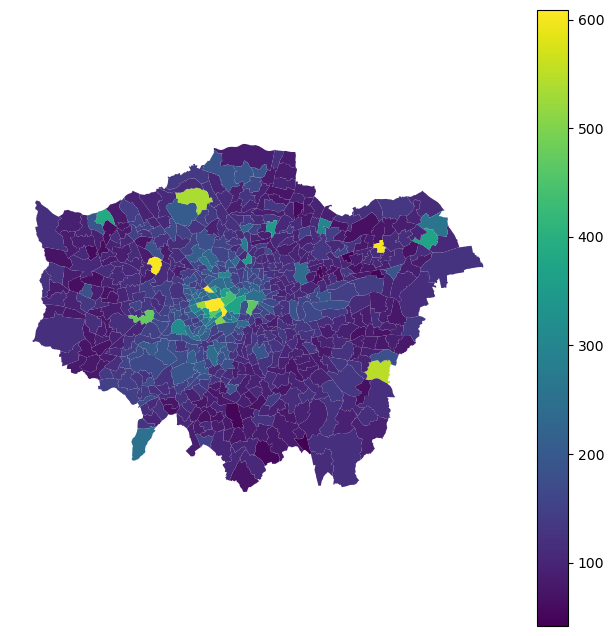

<Figure size 800x800 with 0 Axes>

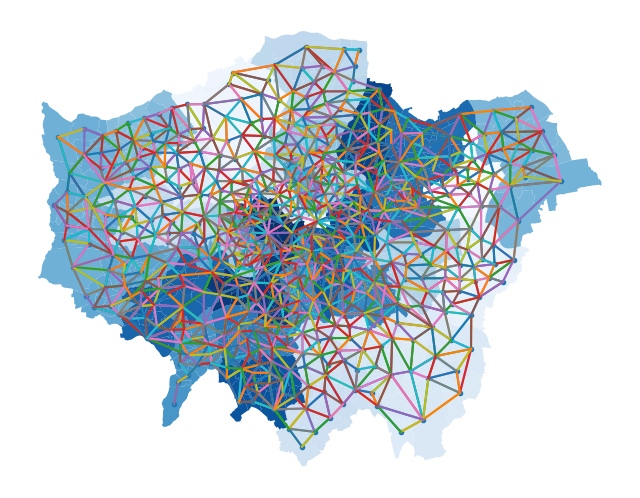

Global Moran's I： 0.4251755584591877
The z-test value under random distribution hypothesis:  18.23100860112638
The p-value of the z-test under random distribution hypothesis:  2.9286978716824874e-74
The z-test value under normal distribution hypothesis:  18.044657603586156
The p-value of the Z test under normal distribution hypothesis:  8.690138055356104e-73


/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


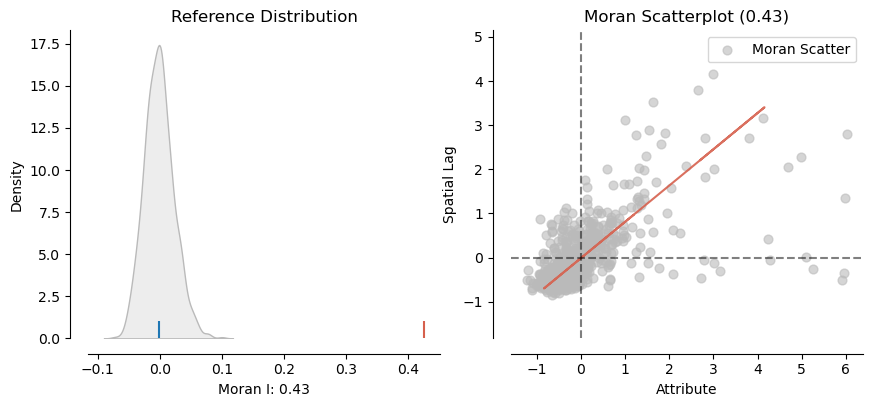

In [21]:
# Calculate Gloval Moran's I


def global_moran(myData, columnName):
    gdf = myData[[columnName, "geometry"]]

    ax = myData.plot(figsize=(8, 8), column=columnName,legend=True)
    ax.set_axis_off()
    plt.savefig('average_price_for_' + columnName + '.png')

    wq = lps.weights.Queen.from_dataframe(gdf)
    wq.transform = "r"
    centroids = gdf.geometry.centroid
    fig = figure(figsize=(8, 8))
    ax = gdf.plot(figsize=(8, 8), cmap="Blues")
    plt.plot(centroids.x, centroids.y, ".")
    for k, neighs in wq.neighbors.items():
        # print(k,neighs)
        origin = centroids[k]
        for neigh in neighs:
            segment = centroids[[k, neigh]]
            plt.plot(segment.x, segment.y, "-")
    plt.axis("off")
    plt.savefig('weight_matrix_for_' + columnName + '.png')
    plt.show()

    y = gdf[columnName]
    mi = esda.moran.Moran(y, wq)

    print("Global Moran's I：", mi.I)
    print("The z-test value under random distribution hypothesis: ", mi.z_rand)
    print("The p-value of the z-test under random distribution hypothesis: ", mi.p_rand)
    print("The z-test value under normal distribution hypothesis: ", mi.z_norm)
    print("The p-value of the Z test under normal distribution hypothesis: ", mi.p_norm)

    plot_moran(mi, zstandard=True, figsize=(10, 4))
    plt.legend(['Moran Scatter'])
    plt.savefig('Moran Scatter_for_' + columnName + '.png')
    plt.show()


global_moran(myData, "average_price")

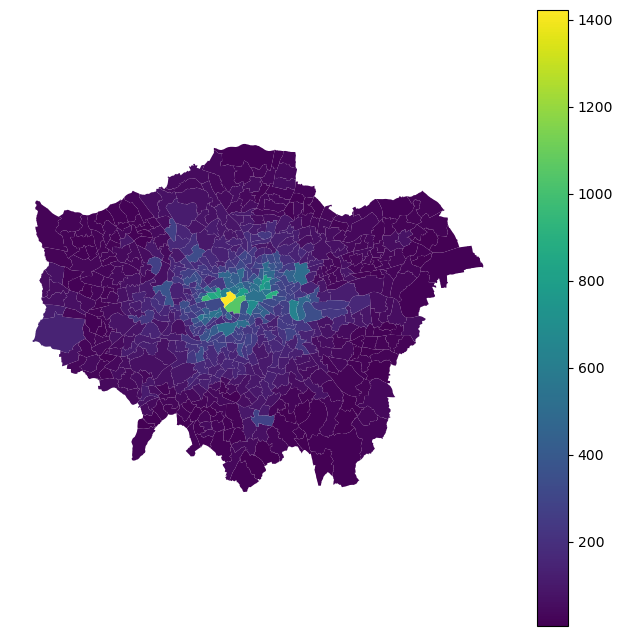

<Figure size 800x800 with 0 Axes>

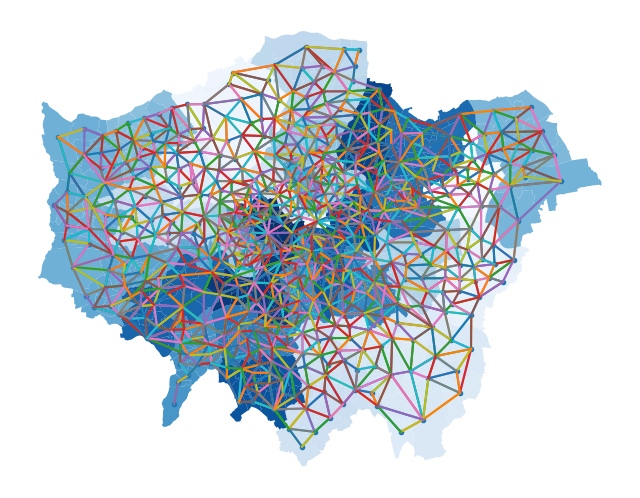

Global Moran's I： 0.7554256506929731
The z-test value under random distribution hypothesis:  32.283209075386196
The p-value of the z-test under random distribution hypothesis:  1.2035930392272867e-228
The z-test value under normal distribution hypothesis:  32.00800184002635
The p-value of the Z test under normal distribution hypothesis:  8.438495568419313e-225


/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


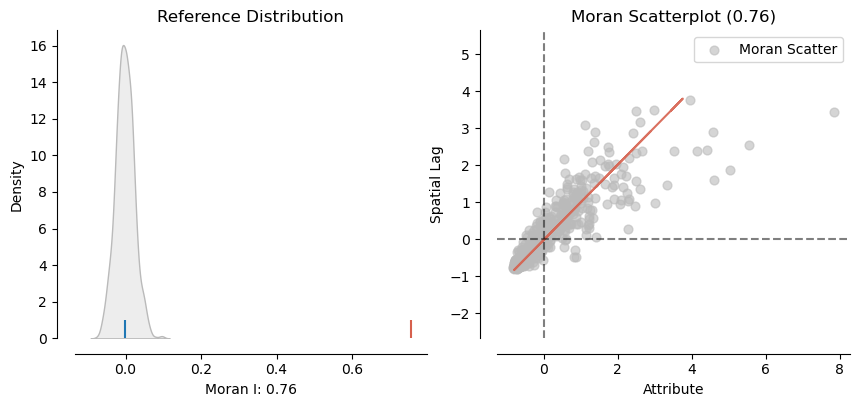

In [22]:
global_moran(myData, "Count_")

## 2.2 Local Moran's I

Wrad Code  loc_moran
0    E09000001   1.572724
1    E05000026   0.033655
2    E05000027   0.086160
3    E05000028   0.095736
4    E05000029  -0.030380
..         ...        ...
620  E05000645   2.765634
621  E05000646   1.987404
622  E05000647   2.599389
623  E05000648   1.354280
624  E05000649  10.184874

[625 rows x 2 columns]

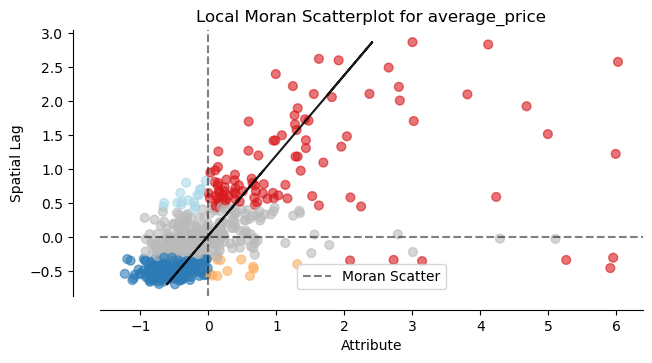

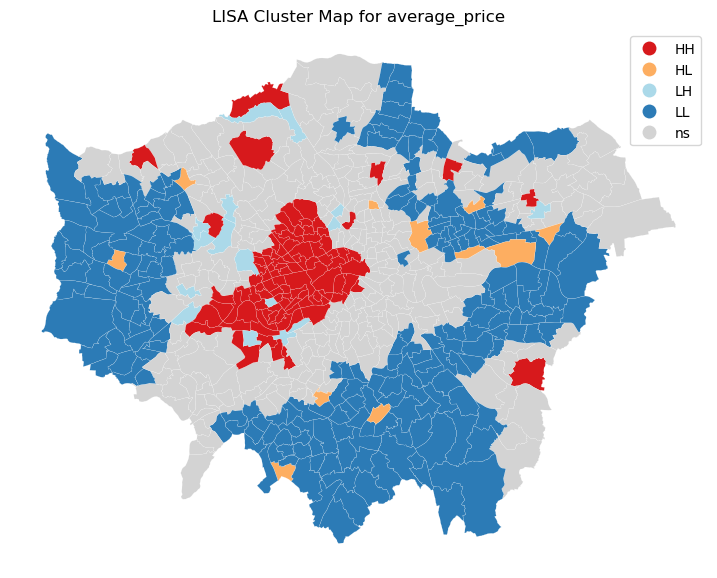

In [23]:
# Calculate Local Moran's I

def local_moran(myData, columnName):
    gdf = myData[[columnName, "geometry", "GSS_CODE"]]
    y = gdf[columnName].values
    w = lps.weights.distance.Kernel.from_dataframe(gdf, fixed=False, k=15)
    w.transform = "r"
    moran_loc = Moran_Local(y, w)
    loc_moran_df = pd.DataFrame(
        {"Wrad Code": gdf["GSS_CODE"], "loc_moran": moran_loc.Is}
    )
    display(loc_moran_df)
    fig, ax = moran_scatterplot(moran_loc, p=0.1, aspect_equal=True)
    ax.set_title('Local Moran Scatterplot for ' + columnName)
    plt.legend(['Moran Scatter'])
    plt.savefig('Local_Moran_Scatterplot_for_' + columnName + '.png')
    plt.show()
    fig, ax = lisa_cluster(moran_loc, gdf, p=0.1, figsize=(9, 9))
    ax.set_title('LISA Cluster Map for ' + columnName)
    plt.savefig('LISA_Cluster_Map_for_' + columnName + '.png')
    plt.show()


local_moran(myData, "average_price")

Wrad Code  loc_moran
0    E09000001   6.174315
1    E05000026   0.165820
2    E05000027   0.493837
3    E05000028   0.456506
4    E05000029   0.502047
..         ...        ...
620  E05000645   0.835153
621  E05000646   0.906883
622  E05000647   2.911162
623  E05000648   1.348908
624  E05000649  33.991451

[625 rows x 2 columns]

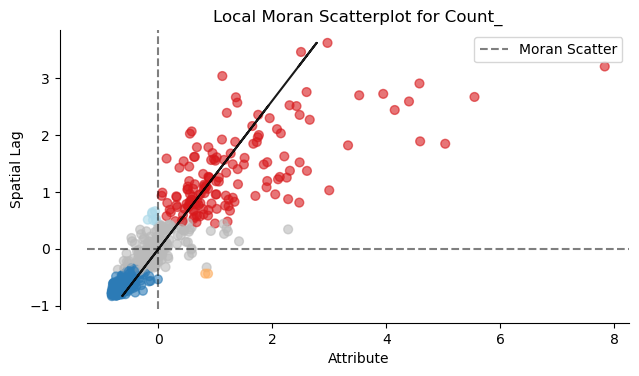

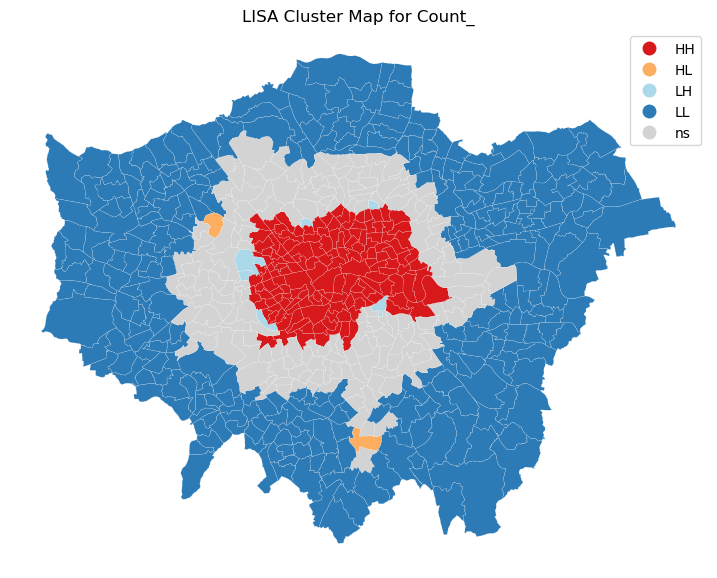

In [24]:
local_moran(myData, "Count_")

# 3. Geographic Weighted Regression

In [25]:
# GWR

import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
def run_gwr(myData,y_column,x_column):
    gdf=myData[[y_column,x_column,'geometry']]
    gdf['centro']=gdf.geometry.centroid
    gdf['X']=gdf.centro.x
    gdf['Y']=gdf.centro.y
    coords = list(zip(gdf['X'],gdf['Y']))
    
    y=gdf[y_column].values.reshape((-1,1))
    y = (y - y.mean(axis=0)) / y.std(axis=0)
    X=gdf[[x_column]].values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    sel = Sel_BW(coords, y, X)
    bw = sel.search()
    print('bw:', bw)
    gwr = GWR(coords, y, X, bw)
    gwr_results = gwr.fit()
    print('aicc:', gwr_results.aicc)
    print('ENP:', gwr_results.ENP)
    print('sigma2:', gwr_results.sigma2)

# The following code throws an error and interrupt on some of our group members' computer while others are not. 
# If an error occurs, please comment the next line, so that the output of coefficient visualisation would not be affected.
    print(gwr_results.summary())
    
    gdf['coe'] = gwr_results.params[:, 1]
    # gdf['r2'] = gwr_results.localR2
    # gdf['r2'] = np.clip(gdf['r2'], -1, 1)

    # classifier_r2 = mc.NaturalBreaks(y=myData[y_column], k=5)
    classifier_coe = mc.NaturalBreaks(y=myData[x_column], k=5)

    # gdf['r2_classified'] = gdf['r2'].apply(classifier_r2)
    gdf['coe_classified'] = gdf['coe'].apply(classifier_coe)
    
    fig, ax = plt.subplots(1,figsize=(18, 9))
    # gdf.plot(column='r2', cmap='coolwarm', legend=True, ax=ax[0])
    gdf.plot(column='coe', cmap='coolwarm', legend=True, ax=ax[1])
    # ax[0].set_title('GWR R2 Result '+ y_column+'~'+x_column)
    # ax[0].axis('off')
    ax[0].set_title('GWR Result '+ y_column+'~'+x_column)
    ax[0].axis('off')
    plt.savefig(f"{x_column}~{y_column}.png")
    plt.show()

In [26]:
run_gwr(myData,"average_price","Income Score (rate)")
run_gwr(myData,"average_price","Employment Score (rate)")
run_gwr(myData,"average_price","Education, Skills and Training Score")
run_gwr(myData,"average_price","Health Deprivation and Disability Score")
run_gwr(myData,"average_price","Crime Score")
run_gwr(myData,"average_price","Barriers to Housing and Services Score")
run_gwr(myData,"average_price","Living Environment Score")

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

bw: 62.0
aicc: 1501.0395743945585
ENP: 51.51568677293291
sigma2: 0.5862671788173865


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
run_gwr(myData,"Count_","Income Score (rate)")
run_gwr(myData,"Count_","Employment Score (rate)")
run_gwr(myData,"Count_","Education, Skills and Training Score")
run_gwr(myData,"Count_","Health Deprivation and Disability Score")
run_gwr(myData,"Count_","Crime Score")
run_gwr(myData,"Count_","Barriers to Housing and Services Score")
run_gwr(myData,"Count_","Living Environment Score")